# NYC Hospitals Data Analysis

## In this notebook, the final data analysis is performed
### 1- The number of hospitals available per-capita within 2Km distance
### 2- Variation of average hospital distances with population
### 3- Variation of hospital availability with population
### 4- Variation of hospital availability with hospital distance



## Importing necessary libraries

In [90]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import geopy.distance
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

### Loading the Hospitals data

In [91]:
NYHoods=pd.read_csv('NYNeighborhoodsWithHospitals.csv')
NYHoods.head()

,Borough,Neighborhood,Latitude,Longitude,NearHos,AvgDist
0,Bronx,Wakefield,40.894705,-73.847201,1,21.154280
1,Bronx,Co-op City,40.874294,-73.829939,7,19.976510
2,Bronx,Eastchester,40.887556,-73.827806,1,21.150140
3,Bronx,Fieldston,40.895437,-73.905643,3,20.148064
4,Bronx,Riverdale,40.890834,-73.912585,8,19.666614


### Loading the population data

Data source:

NYC OpenData

https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp

In [92]:
NYHoodsPop=pd.read_csv('NYNeighborhoodsPopulation.csv')
#NYHoodsPop=NYHoodsPop.set_index('NTA Name')
print(NYHoodsPop.shape)
NYHoodsPop.tail()

(390, 6)


,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
385,Staten Island,2010,85,SI37,Stapleton-Rosebank,26453
386,Staten Island,2010,85,SI45,New Dorp-Midland Beach,21896
387,Staten Island,2010,85,SI48,Arden Heights,25238
388,Staten Island,2010,85,SI54,Great Kills,40720
389,Staten Island,2010,85,SI99,park-cemetery-etc-Staten Island,0


## In the following cell:
### 1- Each data set is compared to the other based on the neighbourhood name, but because there are discripencies, some neighbourhoods are not available under the same name, or not available at all
### 2- The Hospital-Density is calculated by deviding the number of near-by hospitals by the population * 10000
### 3- The average distance to a hospital is multiplid by the population as an indicator of the sparcity of service per capita

In [80]:
#AvgDist=pd.DataFrame([])
#NearHos=pd.DataFrame([])
Record=pd.DataFrame([])
for Borough,Neighborhood,Latitude,Longitude,NearHos,AvgDist in zip(NYHoods['Borough'] , NYHoods['Neighborhood'], NYHoods['Latitude'], NYHoods['Longitude'], NYHoods['NearHos'], NYHoods['AvgDist']):
    print(Neighborhood)
    for N2,Pop in zip(NYHoodsPop['NTA Name'], NYHoodsPop['Population']):
        if (N2.upper() in Neighborhood.upper()) or (Neighborhood.upper() in N2.upper()):
            if NearHos==0:
                Record=Record.append([[Borough,Neighborhood,Latitude,Longitude,NearHos,AvgDist,Pop,'NaN',Pop/AvgDist]])
            else:
                Record=Record.append([[Borough,Neighborhood,Latitude,Longitude,NearHos,AvgDist,Pop,10000*NearHos/Pop,Pop*AvgDist/10000]])
            break
Record.columns=['Borough','Neighborhood','Latitude','Longitude','NearHos','AvgDist','Population','HospDensity','Pop*Dist']

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [81]:
Record=Record.reset_index(drop=True)

Record.shape

(248, 9)

In [82]:
Record.tail()

,Borough,Neighborhood,Latitude,Longitude,NearHos,AvgDist,Population,HospDensity,Pop*Dist
243,Manhattan,Hudson Yards,40.756658,-74.000111,27,12.264738,55839,4.83533,68.485070
244,Queens,Hammels,40.587338,-73.805530,0,22.586070,31645,NaN,1401.084831
245,Queens,Bayswater,40.611322,-73.765968,3,22.610268,48344,0.620553,109.307079
246,Queens,Queensbridge,40.756091,-73.945631,93,11.069510,21104,44.0675,23.361095
247,Staten Island,Fox Hills,40.617311,-74.081740,3,20.389055,19834,1.51255,40.439652


### Results saved in a CSV file

In [62]:
Record.to_csv('NYNeighborhoodsWithHospitalsPop.csv', index=False)

In [63]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
NYLat = location.latitude
NYLng = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(NYLat, NYLng))
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[NYLat, NYLng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Record['Latitude'], Record['Longitude'], Record['Borough'], Record['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Results Visualization and Discussion

In [71]:
import matplotlib.pyplot as plt


## Near-By hospitals versus Population

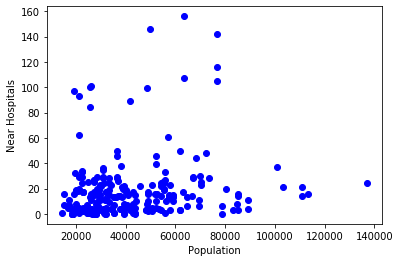

In [75]:
plt.scatter(np.array(Record.loc[:, 'Population']), np.array(Record.loc[:, 'NearHos']),  color='blue')
plt.xlabel("Population")
plt.ylabel("Near Hospitals")
plt.show()

#### In the above scatter plot, the points' distributin clearly shows that the most-populated negbourhoods have the least number of near-by hospitals!

## Average Distance vs Population

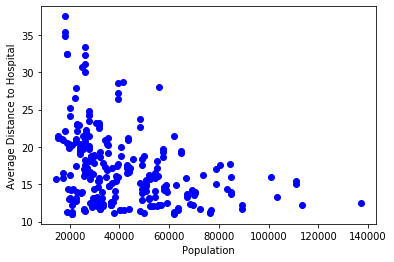

In [86]:
plt.scatter(np.array(Record.loc[:, 'Population']), np.array(Record.loc[:, 'AvgDist']),  color='blue')
plt.xlabel("Population")
plt.ylabel("Average Distance to Hospital")
plt.show()

#### The above scatter plot shows that the most populated neghbourhoods have quite low average distance to hospitals. This reflects that the highest populatin densities are somewhat at central locations within the city, making the average distance low
#### On the other hand, the neighbourhoods with the highest average distances to hospitals are the onew with lowest population. This is a reflection of the population that is locates in the suburbs of the city

## Near-By Hospitals vs Population

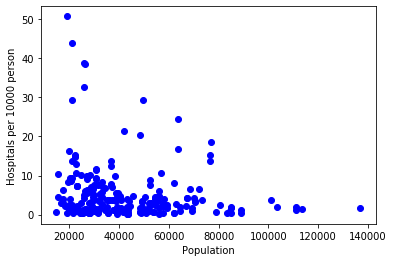

In [83]:
plt.scatter(np.array(Record.loc[:, 'Population']), np.array(Record.loc[:, 'HospDensity']),  color='blue')
plt.xlabel("Population")
plt.ylabel("Hospitals per 10000 person")
plt.show()

#### The above scatter plot shows that the neighbourhoods with the highest densities are the ones with the lowest level of hospitals of per population. This does not actually add any extra information to the data as it is natural to have such distribution

## Average Distance vs Hospital Density

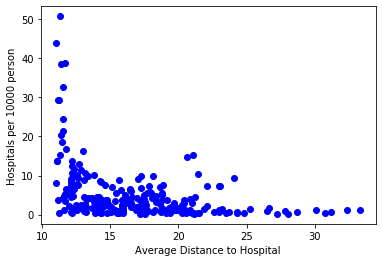

In [89]:
plt.scatter(np.array(Record.loc[:, 'AvgDist']), np.array(Record.loc[:, 'HospDensity']),  color='blue')
plt.xlabel("Average Distance to Hospital")
plt.ylabel("Hospitals per 10000 person")
plt.show()

### This plot clearly distinguishes three categories of hospitals
#### 1- High hospital density and Low average distance - BEST SERVED
#### 2- Low hospital density and Low average distance - Moderately served
#### 3- Low hospital density and Highe average distance - WORST SERVED

#### No districts may be categorized as High hospital density and High average distance naturally

# Conclusions

The best-served and worst-served neighbourhoods are a minority of the neghbourhoods indicating, generally, adequate hospital sevice distribution

The worst-served neihbourhoods need more hospitals in the near-by areas to reduce the average distance to hospital case